# Netflix Recommender System

추천 시스템(recommender system)이란 사용자(user)가 상품(item)에 대해 어떻게 평가하는지 예측하는 시스템의 일종이다. Netflix에서 제공한 netflix-prize-data의 경우 17770개의 영화에 대한 고객 2649429명 평점 정보가 저장되어있다. 이 정보를 가지고 사용자가 아직 평가하지 않은 영화에 대한 평점을 예측하는 것이 이번 프로젝트의 목표이다.

# Surprise 패키지

이번 프로젝트에서는 파이썬의 Surprise 패키지를 사용하여 추천 시스템을 구현해 본다. Surprise 패키지는 Nicola Hug가 만든 오픈 소스 추천 시스템 패키로 문서화가 잘 되어 있다.

- https://github.com/NicolasHug/Surprise

# 데이터

넷플릭스에서 제공하는 netflix-prize-data를 사용한다.
- https://www.kaggle.com/netflix-inc/netflix-prize-data


### Netflix-prize-data INFO

CustomerID,Rating,Date
    - MovieIDs range from 1 to 17770 sequentially.
    - CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
    - Ratings are on a five star (integral) scale from 1 to 5.
    - Dates have the format YYYY-MM-DD.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import surprise

## 데이터 전처리

- netflix-prize-data의 combined_data_1.txt를 오픈
- surprise 패키지에 사용하기 위한 custom_data_file 생성

In [41]:
data_file = open("/Users/limjungmin/Netflix_Recommender/netflix-prize-data/combined_data_1.txt")
# combined_data_1.txt에는 4499개의 movieID가 저장되어있음.

custom_data_file = open("/Users/limjungmin/Netflix_Recommender/u.data", 'w')

- 원본데이터의 경우
    
    movieID:
    userID, Rank, Date 의 형태로 저장되어있다.
   
   
- Surprise 패키지를 사용하기위해 dataset을 custom 해줘야하는데

    userID; movieID; Rank 의 형태로 파일을 수정해야한다.
   
    
   

In [42]:
#cnt = 0
for line in data_file:

    if ":" in line:
        movieID = line.split(":")[0]
        #print(movieID)
        cnt+=1
    else :
        
        info = line.split(",")

        userID = info[0]
        rating = info[1]
        date = info[2].split('\n')[0]

    str = userID + ";" + movieID + ";" + rating + "\r\n"
    custom_data_file.write(str)
    
    #if cnt > 50 : break
    
print("Done")

Done


## Use a custom dataset
참고: https://surprise.readthedocs.io/en/latest/getting_started.html#use-a-custom-dataset

In [43]:
reader = surprise.Reader(line_format='user item rating', sep=';')

In [44]:
data = surprise.Dataset.load_from_file('/Users/limjungmin/Netflix_Recommender/u.data', reader=reader)

In [45]:
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df["id"]

- 포맷 변경후 dataframe으로 변환하여 저장 후 출력 (테스트를 위해 50개의 영화를 대상으로만 진행)

In [46]:
df.head(10)

,user,item,rate
0,217506,1,2.0
1,1488844,1,3.0
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
5,823519,1,3.0
6,893988,1,3.0
7,124105,1,4.0
8,1248029,1,3.0
9,1842128,1,4.0


## 학습 

- Surprise 패키지의 train_test_split()를 통해 훈련셋, 테스트셋을 나누어 예측값과 실제값의 비교를 간편히 진행할 수 있다.
- 훈련에 사용한 알고리즘은 netflix prize에서 높은 성능을 보였던 SVD를 사용.

In [47]:
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

In [48]:
trainset, testset = train_test_split(data, test_size=.25)

In [60]:
testset[1:10]

[('1830000', '1336', 3.0),
 ('1695685', '3893', 3.0),
 ('112076', '1608', 5.0),
 ('1699258', '312', 2.0),
 ('554529', '2122', 4.0),
 ('1006933', '1865', 3.0),
 ('1980305', '886', 5.0),
 ('1472689', '3369', 3.0),
 ('452860', '1582', 4.0)]

In [51]:
algo = SVD()

In [52]:
algo.fit(trainset)

## 결과(평가)

- RMSE : 0.9028

In [53]:
predictions = algo.test(testset)

In [59]:
predictions[1:10]

[Prediction(uid='1830000', iid='1336', r_ui=3.0, est=2.983732581560073, details={'was_impossible': False}),
 Prediction(uid='1695685', iid='3893', r_ui=3.0, est=4.006716702498658, details={'was_impossible': False}),
 Prediction(uid='112076', iid='1608', r_ui=5.0, est=3.804846493184515, details={'was_impossible': False}),
 Prediction(uid='1699258', iid='312', r_ui=2.0, est=3.2595075184234363, details={'was_impossible': False}),
 Prediction(uid='554529', iid='2122', r_ui=4.0, est=4.513199549657152, details={'was_impossible': False}),
 Prediction(uid='1006933', iid='1865', r_ui=3.0, est=4.129186367965074, details={'was_impossible': False}),
 Prediction(uid='1980305', iid='886', r_ui=5.0, est=3.945246423053396, details={'was_impossible': False}),
 Prediction(uid='1472689', iid='3369', r_ui=3.0, est=4.144264687593944, details={'was_impossible': False}),
 Prediction(uid='452860', iid='1582', r_ui=4.0, est=3.438297255190142, details={'was_impossible': False})]

In [61]:
print(accuracy.rmse(predictions))

RMSE: 0.9028
0.9027793490017464


## 결과 설명

[그림1 - testset으로 사용될 데이터]
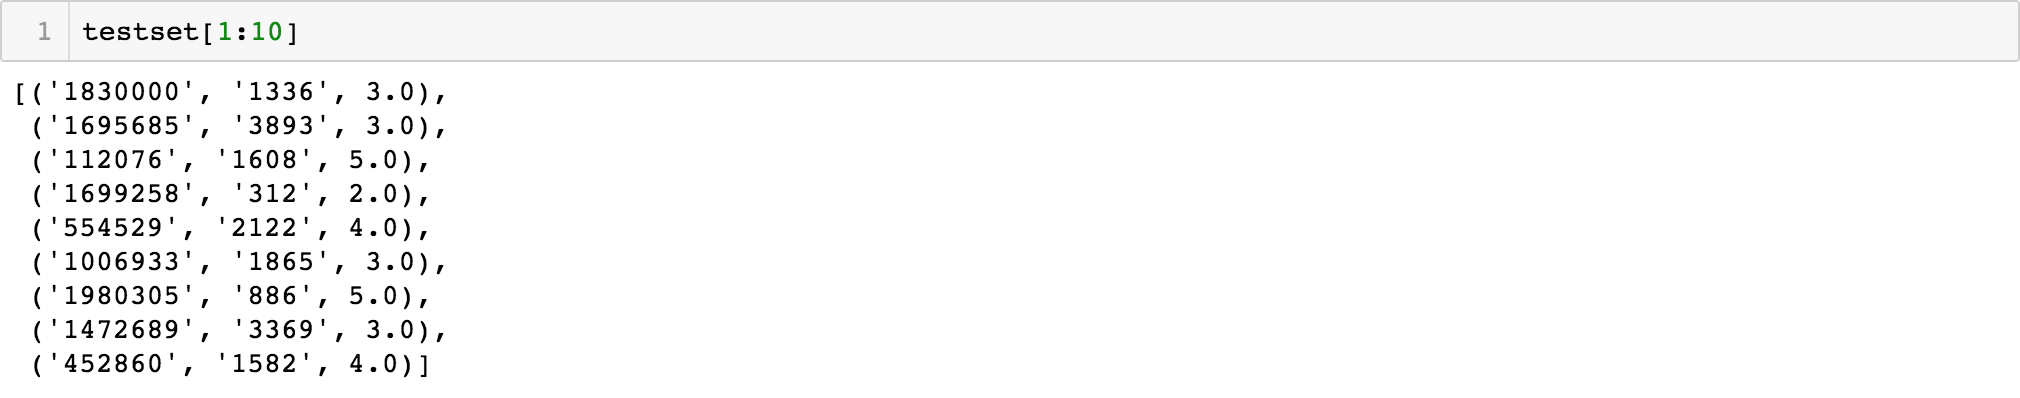

[그림2 - 실제값과 예측값 ]
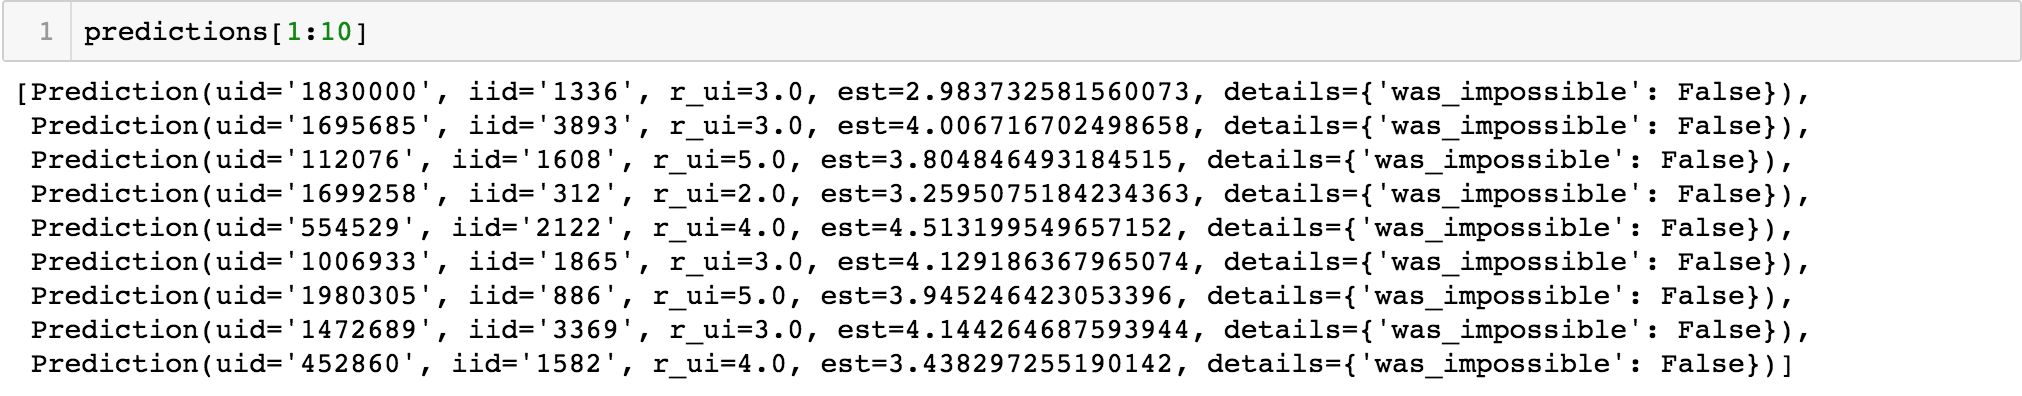

위와 같이 uid는 userID이며 r_ui는 실제값이다. 추정치는 est로 표시된 값이며 각각의 추정치는 실제값과 +1 사이로 예측되고 있다.

- Prediction(uid='1830000', iid='1336', r_ui=3.0, est=2.983732581560073, details={'was_impossible': False})

- '1830000' 사용자가 내린 평점은 3.0, SVD 알고리즘으로 추정한 예측값은 2.9837...

RMSE(평균제곱오차)는 0.9028로 결과를 나타내고 있다.
- (0에 가까울 수록 예측률이 좋다, 0.9028이란 오차범위 +- 0.9028과 비슷하다)

- 코드 링크

https://github.com/csjungminlim/MatrixCompletion/blob/master/recommender_using_Surprise.py
